In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models.resnet import ResNet18_Weights
import cv2
import os
import numpy as np
from PIL import Image

# Configuration
CROP_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
import random
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class PairedArtworkDataset(Dataset):
    def __init__(self, sketch_dir, artwork_dir, min_size=CROP_SIZE):
        self.pairs = []
        self.min_size = min_size

        for fname in os.listdir(artwork_dir):
            sketch_path = os.path.join(sketch_dir, fname)
            artwork_path = os.path.join(artwork_dir, fname)
            if os.path.exists(sketch_path):
                sketch_size = Image.open(sketch_path).size
                artwork_size = Image.open(artwork_path).size
                if (sketch_size[0] >= min_size and sketch_size[1] >= min_size and
                    artwork_size[0] >= min_size and artwork_size[1] >= min_size):
                    self.pairs.append((sketch_path, artwork_path))
                else:
                    print(f"Skipping {fname} - minimum size not met")

        self.sketch_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        self.artwork_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        sketch_path, artwork_path = self.pairs[idx]
        sketch = Image.open(sketch_path).convert('L')
        artwork = Image.open(artwork_path).convert('RGB')

        # Resize and crop
        sketch = sketch.resize((self.min_size, self.min_size), Image.BICUBIC)
        artwork = artwork.resize((self.min_size, self.min_size), Image.BICUBIC)
        sketch = transforms.CenterCrop(self.min_size)(sketch)
        artwork = transforms.CenterCrop(self.min_size)(artwork)

        # Random horizontal flip (applied to both)
        if random.random() > 0.5:
            sketch = sketch.transpose(Image.FLIP_LEFT_RIGHT)
            artwork = artwork.transpose(Image.FLIP_LEFT_RIGHT)

        sketch = self.sketch_transform(sketch)
        artwork = self.artwork_transform(artwork)
        return {'sketch': sketch, 'artwork': artwork}

In [65]:
# 2. Modified Generator with Dynamic Initialization
class ResNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        
        # Adaptive first layer for grayscale input
        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Initialize with pretrained weights (average RGB channels)
        with torch.no_grad():
            pretrained_conv1 = resnet.conv1.weight.data
            self.initial[0].weight.data = pretrained_conv1.mean(dim=1, keepdim=True)

        # Feature extraction
        self.resnet_blocks = nn.ModuleList([
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        ])

        # Upsampling with skip connections
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        for block in self.resnet_blocks:
            x = block(x)
        return self.decoder(x)

In [66]:
import torch.nn as nn
from torch.nn.utils import spectral_norm

class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(4, 64, 4, stride=2, padding=1)),  # Input: sketch (1) + artwork (3)
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(64, 128, 4, stride=2, padding=1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(128, 256, 4, stride=2, padding=1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(256, 512, 4, stride=1, padding=1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)  # Output: 30x30 grid
            # No Sigmoid here as we use BCEWithLogitsLoss
        )
    
    def forward(self, sketch, artwork):
        x = torch.cat([sketch, artwork], dim=1)  # Concatenate along channel dimension
        return self.model(x)

In [67]:
# Initialize dataset and loader
dataset = PairedArtworkDataset('sketches2', 'artworks')
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Model initialization
generator = ResNetGenerator().to(DEVICE)
discriminator = PatchGANDiscriminator().to(DEVICE)  # Use previous Discriminator

# Optimizers
opt_g = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_d = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

# Loss functions
criterion_gan = nn.BCEWithLogitsLoss()
criterion_l1 = nn.L1Loss()

Skipping 297439.jpg - minimum size not met
Skipping 314626.jpg - minimum size not met
Skipping 314636.jpg - minimum size not met
Skipping 314637.jpg - minimum size not met
Skipping 314718.jpg - minimum size not met
Skipping 314719.jpg - minimum size not met
Skipping 314720.jpg - minimum size not met
Skipping 314736.jpg - minimum size not met
Skipping 314743.jpg - minimum size not met
Skipping 314747.jpg - minimum size not met
Skipping 317518.jpg - minimum size not met
Skipping 317541.jpg - minimum size not met
Skipping 317543.jpg - minimum size not met
Skipping 317555.jpg - minimum size not met
Skipping 317573.jpg - minimum size not met
Skipping 317579.jpg - minimum size not met
Skipping 317588.jpg - minimum size not met
Skipping 317602.jpg - minimum size not met
Skipping 317613.jpg - minimum size not met
Skipping 318419.jpg - minimum size not met
Skipping 318424.jpg - minimum size not met
Skipping 318428.jpg - minimum size not met
Skipping 318436.jpg - minimum size not met
Skipping 31

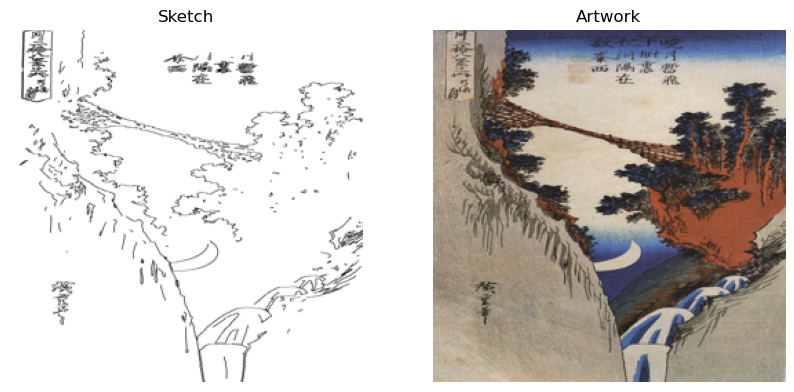

In [62]:
import matplotlib.pyplot as plt

# Get the first item from the dataset
first_item = dataset[0]
sketch = first_item['sketch'].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for plotting
artwork = first_item['artwork'].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for plotting

# Denormalize the images from [-1, 1] to [0, 1]
artwork = (artwork * 0.5) + 0.5

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sketch, cmap='gray')
axes[0].set_title('Sketch')
axes[0].axis('off')

axes[1].imshow(artwork)
axes[1].set_title('Artwork')
axes[1].axis('off')

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import os
import matplotlib.pyplot as plt

# Configuration
CROP_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT_DIR = 'checkpoints'
LOG_DIR = 'runs/gan_experiment'

# Initialize models, optimizers, and losses
generator = ResNetGenerator().to(DEVICE)
discriminator = PatchGANDiscriminator().to(DEVICE)
opt_g = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_d = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
criterion_gan = nn.BCEWithLogitsLoss()
criterion_l1 = nn.L1Loss()

# Dataset and DataLoader
dataset = PairedArtworkDataset('sketches2', 'artworks')
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Logging setup
writer = SummaryWriter(LOG_DIR)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Training loop
for epoch in range(EPOCHS):
    for i, batch in enumerate(loader):
        sketch = batch['sketch'].to(DEVICE)
        real_artwork = batch['artwork'].to(DEVICE)

        # Train Discriminator
        opt_d.zero_grad()
        generated_artwork = generator(sketch).detach()
        disc_real = discriminator(sketch, real_artwork)
        disc_fake = discriminator(sketch, generated_artwork)
        disc_loss_real = criterion_gan(disc_real, torch.full_like(disc_real, 0.9))  # Label smoothing
        disc_loss_fake = criterion_gan(disc_fake, torch.full_like(disc_fake, 0.1))
        disc_loss = 0.5 * (disc_loss_real + disc_loss_fake)
        disc_loss.backward()
        opt_d.step()

        # Train Generator
        opt_g.zero_grad()
        generated_artwork = generator(sketch)
        disc_fake = discriminator(sketch, generated_artwork)
        gen_loss_gan = criterion_gan(disc_fake, torch.full_like(disc_fake, 0.9))  # Label smoothing
        gen_loss_l1 = criterion_l1(generated_artwork, real_artwork)
        gen_loss = gen_loss_gan + 100 * gen_loss_l1  # L1 weight = 100
        gen_loss.backward()
        opt_g.step()

        # Logging
        if i % 10 == 0:
            writer.add_scalar('Loss/Discriminator', disc_loss.item(), epoch * len(loader) + i)
            writer.add_scalar('Loss/Generator_GAN', gen_loss_gan.item(), epoch * len(loader) + i)
            writer.add_scalar('Loss/Generator_L1', gen_loss_l1.item(), epoch * len(loader) + i)
            writer.add_scalar('Loss/Generator_Total', gen_loss.item(), epoch * len(loader) + i)
            print(f"Epoch [{epoch}/{EPOCHS}] Batch [{i}/{len(loader)}] "
                  f"D Loss: {disc_loss.item():.4f} G Loss: {gen_loss.item():.4f}")

        # Log generated images
        if i % 100 == 0:
            with torch.no_grad():
                img = generated_artwork[0].cpu() * 0.5 + 0.5  # Denormalize
                writer.add_image('Generated', img, epoch * len(loader) + i)

    # Save checkpoint every 10 epochs
    if epoch % 10 == 0:
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'opt_g_state_dict': opt_g.state_dict(),
            'opt_d_state_dict': opt_d.state_dict(),
        }
        torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch}.pth'))

writer.close()

Epoch 1/100: 100%|██████████| 69/69 [04:31<00:00,  3.93s/it, D Loss=0.5035, G Loss=41.3422, Avg D=0.5452, Avg G=47.8147]



Epoch 1/100 | Avg D Loss: 0.5452 | Avg G Loss: 47.8147


Epoch 2/100: 100%|██████████| 69/69 [04:29<00:00,  3.91s/it, D Loss=0.5032, G Loss=40.2008, Avg D=0.5035, Avg G=43.0819]



Epoch 2/100 | Avg D Loss: 0.5035 | Avg G Loss: 43.0819


Epoch 3/100: 100%|██████████| 69/69 [04:30<00:00,  3.92s/it, D Loss=0.5032, G Loss=37.9615, Avg D=0.5032, Avg G=41.6389]



Epoch 3/100 | Avg D Loss: 0.5032 | Avg G Loss: 41.6389


Epoch 4/100: 100%|██████████| 69/69 [02:49<00:00,  2.45s/it, D Loss=0.5032, G Loss=46.2561, Avg D=0.5032, Avg G=40.7336]



Epoch 4/100 | Avg D Loss: 0.5032 | Avg G Loss: 40.7336


Epoch 5/100: 100%|██████████| 69/69 [02:08<00:00,  1.87s/it, D Loss=0.5032, G Loss=33.9579, Avg D=0.5032, Avg G=39.5634]



Epoch 5/100 | Avg D Loss: 0.5032 | Avg G Loss: 39.5634


Epoch 6/100: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, D Loss=0.5032, G Loss=31.2169, Avg D=0.5032, Avg G=38.6311]



Epoch 6/100 | Avg D Loss: 0.5032 | Avg G Loss: 38.6311


Epoch 7/100: 100%|██████████| 69/69 [02:09<00:00,  1.87s/it, D Loss=0.5032, G Loss=31.6868, Avg D=0.5032, Avg G=37.9343]



Epoch 7/100 | Avg D Loss: 0.5032 | Avg G Loss: 37.9343


Epoch 8/100: 100%|██████████| 69/69 [02:09<00:00,  1.87s/it, D Loss=0.5032, G Loss=31.2418, Avg D=0.5032, Avg G=36.9303]



Epoch 8/100 | Avg D Loss: 0.5032 | Avg G Loss: 36.9303


Epoch 9/100: 100%|██████████| 69/69 [02:09<00:00,  1.87s/it, D Loss=0.5032, G Loss=27.8792, Avg D=0.5032, Avg G=35.2035]



Epoch 9/100 | Avg D Loss: 0.5032 | Avg G Loss: 35.2035


Epoch 10/100: 100%|██████████| 69/69 [02:10<00:00,  1.89s/it, D Loss=0.5032, G Loss=30.6242, Avg D=0.5032, Avg G=34.7829]



Epoch 10/100 | Avg D Loss: 0.5032 | Avg G Loss: 34.7829


Epoch 11/100: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, D Loss=0.5032, G Loss=26.9793, Avg D=0.5032, Avg G=32.4405]



Epoch 11/100 | Avg D Loss: 0.5032 | Avg G Loss: 32.4405


Epoch 12/100: 100%|██████████| 69/69 [02:08<00:00,  1.87s/it, D Loss=0.5032, G Loss=24.2217, Avg D=0.5032, Avg G=30.6005]



Epoch 12/100 | Avg D Loss: 0.5032 | Avg G Loss: 30.6005


Epoch 13/100: 100%|██████████| 69/69 [02:12<00:00,  1.92s/it, D Loss=0.5032, G Loss=25.9685, Avg D=0.5032, Avg G=30.0183]



Epoch 13/100 | Avg D Loss: 0.5032 | Avg G Loss: 30.0183


Epoch 14/100: 100%|██████████| 69/69 [02:10<00:00,  1.89s/it, D Loss=0.5032, G Loss=30.6806, Avg D=0.5032, Avg G=28.3737]



Epoch 14/100 | Avg D Loss: 0.5032 | Avg G Loss: 28.3737


Epoch 15/100: 100%|██████████| 69/69 [02:09<00:00,  1.88s/it, D Loss=0.5032, G Loss=27.5085, Avg D=0.5032, Avg G=28.5984]



Epoch 15/100 | Avg D Loss: 0.5032 | Avg G Loss: 28.5984


Epoch 16/100: 100%|██████████| 69/69 [02:10<00:00,  1.89s/it, D Loss=0.5032, G Loss=23.3828, Avg D=0.5032, Avg G=26.4497]



Epoch 16/100 | Avg D Loss: 0.5032 | Avg G Loss: 26.4497


Epoch 17/100: 100%|██████████| 69/69 [02:09<00:00,  1.88s/it, D Loss=0.5032, G Loss=21.4643, Avg D=0.5032, Avg G=25.6873]



Epoch 17/100 | Avg D Loss: 0.5032 | Avg G Loss: 25.6873


Epoch 18/100: 100%|██████████| 69/69 [02:10<00:00,  1.89s/it, D Loss=0.5032, G Loss=31.7796, Avg D=0.5032, Avg G=25.1538]



Epoch 18/100 | Avg D Loss: 0.5032 | Avg G Loss: 25.1538


Epoch 19/100: 100%|██████████| 69/69 [02:10<00:00,  1.88s/it, D Loss=0.5032, G Loss=27.3603, Avg D=0.5032, Avg G=24.6095]



Epoch 19/100 | Avg D Loss: 0.5032 | Avg G Loss: 24.6095


Epoch 20/100: 100%|██████████| 69/69 [02:10<00:00,  1.89s/it, D Loss=0.5032, G Loss=24.8881, Avg D=0.5032, Avg G=24.1012]



Epoch 20/100 | Avg D Loss: 0.5032 | Avg G Loss: 24.1012


Epoch 21/100: 100%|██████████| 69/69 [02:09<00:00,  1.88s/it, D Loss=0.5032, G Loss=21.3108, Avg D=0.5032, Avg G=23.3838]



Epoch 21/100 | Avg D Loss: 0.5032 | Avg G Loss: 23.3838


Epoch 22/100: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, D Loss=0.5032, G Loss=28.5702, Avg D=0.5032, Avg G=23.0716]



Epoch 22/100 | Avg D Loss: 0.5032 | Avg G Loss: 23.0716


Epoch 23/100: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, D Loss=0.5032, G Loss=20.5399, Avg D=0.5032, Avg G=22.7400]



Epoch 23/100 | Avg D Loss: 0.5032 | Avg G Loss: 22.7400


Epoch 24/100: 100%|██████████| 69/69 [02:07<00:00,  1.85s/it, D Loss=0.5032, G Loss=30.7080, Avg D=0.5032, Avg G=22.5543]



Epoch 24/100 | Avg D Loss: 0.5032 | Avg G Loss: 22.5543


Epoch 25/100: 100%|██████████| 69/69 [02:07<00:00,  1.85s/it, D Loss=0.5032, G Loss=25.1717, Avg D=0.5032, Avg G=22.1640]



Epoch 25/100 | Avg D Loss: 0.5032 | Avg G Loss: 22.1640


Epoch 26/100: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, D Loss=0.5032, G Loss=20.3936, Avg D=0.5032, Avg G=21.9529]



Epoch 26/100 | Avg D Loss: 0.5032 | Avg G Loss: 21.9529


Epoch 27/100: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, D Loss=0.5032, G Loss=27.1770, Avg D=0.5032, Avg G=21.5552]



Epoch 27/100 | Avg D Loss: 0.5032 | Avg G Loss: 21.5552


Epoch 28/100: 100%|██████████| 69/69 [02:08<00:00,  1.87s/it, D Loss=0.5032, G Loss=16.5183, Avg D=0.5032, Avg G=21.0725]



Epoch 28/100 | Avg D Loss: 0.5032 | Avg G Loss: 21.0725


Epoch 29/100: 100%|██████████| 69/69 [02:07<00:00,  1.85s/it, D Loss=0.5032, G Loss=21.2556, Avg D=0.5032, Avg G=21.0003]



Epoch 29/100 | Avg D Loss: 0.5032 | Avg G Loss: 21.0003


Epoch 30/100: 100%|██████████| 69/69 [02:09<00:00,  1.88s/it, D Loss=0.5032, G Loss=16.6991, Avg D=0.5032, Avg G=20.6844]



Epoch 30/100 | Avg D Loss: 0.5032 | Avg G Loss: 20.6844


Epoch 31/100: 100%|██████████| 69/69 [02:08<00:00,  1.87s/it, D Loss=0.5032, G Loss=16.9127, Avg D=0.5032, Avg G=20.5346]



Epoch 31/100 | Avg D Loss: 0.5032 | Avg G Loss: 20.5346


Epoch 32/100: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, D Loss=0.5032, G Loss=18.7015, Avg D=0.5032, Avg G=20.0865]



Epoch 32/100 | Avg D Loss: 0.5032 | Avg G Loss: 20.0865


Epoch 33/100: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, D Loss=0.5032, G Loss=17.3102, Avg D=0.5032, Avg G=19.5996]



Epoch 33/100 | Avg D Loss: 0.5032 | Avg G Loss: 19.5996


Epoch 34/100: 100%|██████████| 69/69 [02:07<00:00,  1.85s/it, D Loss=0.5032, G Loss=20.6493, Avg D=0.5032, Avg G=19.5269]



Epoch 34/100 | Avg D Loss: 0.5032 | Avg G Loss: 19.5269


Epoch 35/100: 100%|██████████| 69/69 [02:07<00:00,  1.85s/it, D Loss=0.5032, G Loss=21.2616, Avg D=0.5032, Avg G=19.2927]



Epoch 35/100 | Avg D Loss: 0.5032 | Avg G Loss: 19.2927


Epoch 36/100: 100%|██████████| 69/69 [02:07<00:00,  1.85s/it, D Loss=0.5032, G Loss=21.7033, Avg D=0.5032, Avg G=19.0469]



Epoch 36/100 | Avg D Loss: 0.5032 | Avg G Loss: 19.0469


Epoch 37/100: 100%|██████████| 69/69 [02:07<00:00,  1.85s/it, D Loss=0.5032, G Loss=18.3446, Avg D=0.5032, Avg G=18.8279]



Epoch 37/100 | Avg D Loss: 0.5032 | Avg G Loss: 18.8279


Epoch 38/100: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, D Loss=0.5032, G Loss=17.7414, Avg D=0.5032, Avg G=18.4501]



Epoch 38/100 | Avg D Loss: 0.5032 | Avg G Loss: 18.4501


Epoch 39/100: 100%|██████████| 69/69 [02:07<00:00,  1.85s/it, D Loss=0.5032, G Loss=20.3210, Avg D=0.5032, Avg G=18.2092]



Epoch 39/100 | Avg D Loss: 0.5032 | Avg G Loss: 18.2092


Epoch 40/100: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, D Loss=0.5032, G Loss=16.8107, Avg D=0.5032, Avg G=18.0243]



Epoch 40/100 | Avg D Loss: 0.5032 | Avg G Loss: 18.0243


Epoch 41/100: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, D Loss=0.5032, G Loss=22.4638, Avg D=0.5032, Avg G=17.9552]



Epoch 41/100 | Avg D Loss: 0.5032 | Avg G Loss: 17.9552


Epoch 42/100: 100%|██████████| 69/69 [02:07<00:00,  1.85s/it, D Loss=0.5032, G Loss=28.4657, Avg D=0.5032, Avg G=17.8628]



Epoch 42/100 | Avg D Loss: 0.5032 | Avg G Loss: 17.8628


Epoch 43/100: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, D Loss=0.5072, G Loss=16.2755, Avg D=0.5033, Avg G=17.5103]



Epoch 43/100 | Avg D Loss: 0.5033 | Avg G Loss: 17.5103


Epoch 44/100: 100%|██████████| 69/69 [02:06<00:00,  1.84s/it, D Loss=0.8133, G Loss=19.1796, Avg D=0.8133, Avg G=16.9802]



Epoch 44/100 | Avg D Loss: 0.8133 | Avg G Loss: 16.9802


Epoch 45/100: 100%|██████████| 69/69 [02:05<00:00,  1.82s/it, D Loss=0.8133, G Loss=14.3392, Avg D=0.8133, Avg G=16.7143]



Epoch 45/100 | Avg D Loss: 0.8133 | Avg G Loss: 16.7143


Epoch 46/100: 100%|██████████| 69/69 [02:06<00:00,  1.84s/it, D Loss=0.8133, G Loss=26.1848, Avg D=0.8133, Avg G=16.7311]



Epoch 46/100 | Avg D Loss: 0.8133 | Avg G Loss: 16.7311


Epoch 47/100: 100%|██████████| 69/69 [02:07<00:00,  1.85s/it, D Loss=0.8133, G Loss=14.6787, Avg D=0.8133, Avg G=16.5271]



Epoch 47/100 | Avg D Loss: 0.8133 | Avg G Loss: 16.5271


Epoch 48/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=14.9479, Avg D=0.8133, Avg G=16.4749]



Epoch 48/100 | Avg D Loss: 0.8133 | Avg G Loss: 16.4749


Epoch 49/100: 100%|██████████| 69/69 [02:12<00:00,  1.93s/it, D Loss=0.8133, G Loss=24.4157, Avg D=0.8133, Avg G=16.4552]



Epoch 49/100 | Avg D Loss: 0.8133 | Avg G Loss: 16.4552


Epoch 50/100: 100%|██████████| 69/69 [02:39<00:00,  2.32s/it, D Loss=0.8133, G Loss=16.9575, Avg D=0.8133, Avg G=16.4686]



Epoch 50/100 | Avg D Loss: 0.8133 | Avg G Loss: 16.4686


Epoch 51/100: 100%|██████████| 69/69 [02:10<00:00,  1.90s/it, D Loss=0.8133, G Loss=15.5516, Avg D=0.8133, Avg G=16.1171]



Epoch 51/100 | Avg D Loss: 0.8133 | Avg G Loss: 16.1171


Epoch 52/100: 100%|██████████| 69/69 [02:08<00:00,  1.86s/it, D Loss=0.8133, G Loss=18.8142, Avg D=0.8133, Avg G=15.9610]



Epoch 52/100 | Avg D Loss: 0.8133 | Avg G Loss: 15.9610


Epoch 53/100: 100%|██████████| 69/69 [02:10<00:00,  1.90s/it, D Loss=0.8133, G Loss=16.2900, Avg D=0.8133, Avg G=15.7975]



Epoch 53/100 | Avg D Loss: 0.8133 | Avg G Loss: 15.7975


Epoch 54/100: 100%|██████████| 69/69 [02:09<00:00,  1.88s/it, D Loss=0.8133, G Loss=15.5058, Avg D=0.8133, Avg G=15.7030]



Epoch 54/100 | Avg D Loss: 0.8133 | Avg G Loss: 15.7030


Epoch 55/100: 100%|██████████| 69/69 [02:07<00:00,  1.84s/it, D Loss=0.8133, G Loss=12.1397, Avg D=0.8133, Avg G=15.6015]



Epoch 55/100 | Avg D Loss: 0.8133 | Avg G Loss: 15.6015


Epoch 56/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=16.3818, Avg D=0.8133, Avg G=15.6536]



Epoch 56/100 | Avg D Loss: 0.8133 | Avg G Loss: 15.6536


Epoch 57/100: 100%|██████████| 69/69 [02:06<00:00,  1.84s/it, D Loss=0.8133, G Loss=11.6080, Avg D=0.8133, Avg G=15.4935]



Epoch 57/100 | Avg D Loss: 0.8133 | Avg G Loss: 15.4935


Epoch 58/100: 100%|██████████| 69/69 [02:07<00:00,  1.84s/it, D Loss=0.8133, G Loss=13.8190, Avg D=0.8133, Avg G=15.5650]



Epoch 58/100 | Avg D Loss: 0.8133 | Avg G Loss: 15.5650


Epoch 59/100: 100%|██████████| 69/69 [02:05<00:00,  1.82s/it, D Loss=0.8133, G Loss=13.5583, Avg D=0.8133, Avg G=15.5424]



Epoch 59/100 | Avg D Loss: 0.8133 | Avg G Loss: 15.5424


Epoch 60/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=18.4396, Avg D=0.8133, Avg G=15.4624]



Epoch 60/100 | Avg D Loss: 0.8133 | Avg G Loss: 15.4624


Epoch 61/100: 100%|██████████| 69/69 [02:05<00:00,  1.82s/it, D Loss=0.8133, G Loss=15.4612, Avg D=0.8133, Avg G=15.3023]



Epoch 61/100 | Avg D Loss: 0.8133 | Avg G Loss: 15.3023


Epoch 62/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=14.3110, Avg D=0.8133, Avg G=15.2048]



Epoch 62/100 | Avg D Loss: 0.8133 | Avg G Loss: 15.2048


Epoch 63/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=11.2490, Avg D=0.8133, Avg G=15.1065]



Epoch 63/100 | Avg D Loss: 0.8133 | Avg G Loss: 15.1065


Epoch 64/100: 100%|██████████| 69/69 [02:06<00:00,  1.84s/it, D Loss=0.8133, G Loss=13.8419, Avg D=0.8133, Avg G=15.0123]



Epoch 64/100 | Avg D Loss: 0.8133 | Avg G Loss: 15.0123


Epoch 65/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=14.4214, Avg D=0.8133, Avg G=14.9707]



Epoch 65/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.9707


Epoch 66/100: 100%|██████████| 69/69 [02:06<00:00,  1.84s/it, D Loss=0.8133, G Loss=14.4180, Avg D=0.8133, Avg G=14.9286]



Epoch 66/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.9286


Epoch 67/100: 100%|██████████| 69/69 [02:07<00:00,  1.85s/it, D Loss=0.8133, G Loss=16.4219, Avg D=0.8133, Avg G=14.9796]



Epoch 67/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.9796


Epoch 68/100: 100%|██████████| 69/69 [02:06<00:00,  1.84s/it, D Loss=0.8133, G Loss=11.9097, Avg D=0.8133, Avg G=14.8965]



Epoch 68/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.8965


Epoch 69/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=16.6433, Avg D=0.8133, Avg G=14.7766]



Epoch 69/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.7766


Epoch 70/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=12.7506, Avg D=0.8133, Avg G=14.6487]



Epoch 70/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.6487


Epoch 71/100: 100%|██████████| 69/69 [02:05<00:00,  1.83s/it, D Loss=0.8133, G Loss=10.8532, Avg D=0.8133, Avg G=14.6962]



Epoch 71/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.6962


Epoch 72/100: 100%|██████████| 69/69 [02:06<00:00,  1.84s/it, D Loss=0.8133, G Loss=11.4016, Avg D=0.8133, Avg G=14.6575]



Epoch 72/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.6575


Epoch 73/100: 100%|██████████| 69/69 [02:05<00:00,  1.82s/it, D Loss=0.8133, G Loss=15.3441, Avg D=0.8133, Avg G=14.5712]



Epoch 73/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.5712


Epoch 74/100: 100%|██████████| 69/69 [02:06<00:00,  1.84s/it, D Loss=0.8133, G Loss=11.6941, Avg D=0.8133, Avg G=14.4601]



Epoch 74/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.4601


Epoch 75/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=17.1445, Avg D=0.8133, Avg G=14.7046]



Epoch 75/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.7046


Epoch 76/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=13.7648, Avg D=0.8133, Avg G=14.5529]



Epoch 76/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.5529


Epoch 77/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=22.9288, Avg D=0.8133, Avg G=14.5932]



Epoch 77/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.5932


Epoch 78/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=15.7837, Avg D=0.8133, Avg G=14.4866]



Epoch 78/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.4866


Epoch 79/100: 100%|██████████| 69/69 [02:07<00:00,  1.84s/it, D Loss=0.8133, G Loss=12.4889, Avg D=0.8133, Avg G=14.4291]



Epoch 79/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.4291


Epoch 80/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=14.0962, Avg D=0.8133, Avg G=14.2990]



Epoch 80/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.2990


Epoch 81/100: 100%|██████████| 69/69 [02:06<00:00,  1.84s/it, D Loss=0.8133, G Loss=15.0017, Avg D=0.8133, Avg G=14.2070]



Epoch 81/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.2070


Epoch 82/100: 100%|██████████| 69/69 [02:07<00:00,  1.84s/it, D Loss=0.8133, G Loss=15.3644, Avg D=0.8133, Avg G=14.3050]



Epoch 82/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.3050


Epoch 83/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=9.4808, Avg D=0.8133, Avg G=14.1474] 



Epoch 83/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.1474


Epoch 84/100: 100%|██████████| 69/69 [02:05<00:00,  1.82s/it, D Loss=0.8133, G Loss=15.7788, Avg D=0.8133, Avg G=14.2035]



Epoch 84/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.2035


Epoch 85/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=15.5108, Avg D=0.8133, Avg G=18.3013]



Epoch 85/100 | Avg D Loss: 0.8133 | Avg G Loss: 18.3013


Epoch 86/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=11.4123, Avg D=0.8133, Avg G=14.5668]



Epoch 86/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.5668


Epoch 87/100: 100%|██████████| 69/69 [02:05<00:00,  1.82s/it, D Loss=0.8133, G Loss=10.3713, Avg D=0.8133, Avg G=14.0673]



Epoch 87/100 | Avg D Loss: 0.8133 | Avg G Loss: 14.0673


Epoch 88/100: 100%|██████████| 69/69 [02:06<00:00,  1.84s/it, D Loss=0.8133, G Loss=9.4242, Avg D=0.8133, Avg G=13.8057] 



Epoch 88/100 | Avg D Loss: 0.8133 | Avg G Loss: 13.8057


Epoch 89/100: 100%|██████████| 69/69 [02:05<00:00,  1.82s/it, D Loss=0.8133, G Loss=12.3695, Avg D=0.8133, Avg G=13.8447]



Epoch 89/100 | Avg D Loss: 0.8133 | Avg G Loss: 13.8447


Epoch 90/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=13.5888, Avg D=0.8133, Avg G=13.7601]



Epoch 90/100 | Avg D Loss: 0.8133 | Avg G Loss: 13.7601


Epoch 91/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=14.2623, Avg D=0.8133, Avg G=13.7719]



Epoch 91/100 | Avg D Loss: 0.8133 | Avg G Loss: 13.7719


Epoch 92/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=15.0465, Avg D=0.8133, Avg G=13.7211]



Epoch 92/100 | Avg D Loss: 0.8133 | Avg G Loss: 13.7211


Epoch 93/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=10.5747, Avg D=0.8133, Avg G=13.7441]



Epoch 93/100 | Avg D Loss: 0.8133 | Avg G Loss: 13.7441


Epoch 94/100: 100%|██████████| 69/69 [02:05<00:00,  1.82s/it, D Loss=0.8133, G Loss=16.3883, Avg D=0.8133, Avg G=13.8219]



Epoch 94/100 | Avg D Loss: 0.8133 | Avg G Loss: 13.8219


Epoch 95/100: 100%|██████████| 69/69 [02:07<00:00,  1.84s/it, D Loss=0.8133, G Loss=10.5440, Avg D=0.8133, Avg G=13.7034]



Epoch 95/100 | Avg D Loss: 0.8133 | Avg G Loss: 13.7034


Epoch 96/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=13.1361, Avg D=0.8133, Avg G=13.7361]



Epoch 96/100 | Avg D Loss: 0.8133 | Avg G Loss: 13.7361


Epoch 97/100: 100%|██████████| 69/69 [02:07<00:00,  1.84s/it, D Loss=0.8133, G Loss=23.0546, Avg D=0.8133, Avg G=13.8174]



Epoch 97/100 | Avg D Loss: 0.8133 | Avg G Loss: 13.8174


Epoch 98/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=14.6758, Avg D=0.8133, Avg G=13.6255]



Epoch 98/100 | Avg D Loss: 0.8133 | Avg G Loss: 13.6255


Epoch 99/100: 100%|██████████| 69/69 [02:06<00:00,  1.83s/it, D Loss=0.8133, G Loss=10.8249, Avg D=0.8133, Avg G=13.5409]



Epoch 99/100 | Avg D Loss: 0.8133 | Avg G Loss: 13.5409


Epoch 100/100: 100%|██████████| 69/69 [02:05<00:00,  1.82s/it, D Loss=0.8133, G Loss=13.6675, Avg D=0.8133, Avg G=13.5994]


Epoch 100/100 | Avg D Loss: 0.8133 | Avg G Loss: 13.5994


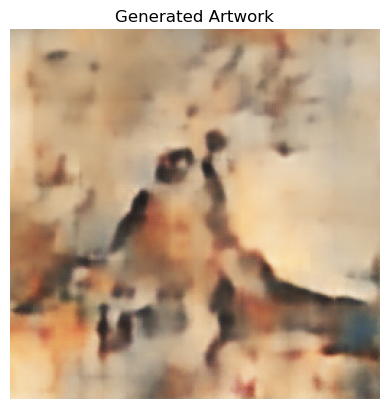

In [56]:
def generate_artwork_from_sketch(sketch_path, generator, device=DEVICE):
    # Load and preprocess the sketch image
    sketch_image = Image.open(sketch_path).convert('L')  # Convert to grayscale
    transform = transforms.Compose([
        transforms.CenterCrop(CROP_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    sketch_tensor = transform(sketch_image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Generate artwork
    generator.eval()
    with torch.no_grad():
        generated_artwork = generator(sketch_tensor)

    # Convert the generated artwork to a numpy array for visualization
    generated_artwork = generated_artwork.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Remove batch dimension and convert to HWC format
    generated_artwork = (generated_artwork * 0.5 + 0.5) * 255  # Denormalize and scale to [0, 255]
    generated_artwork = generated_artwork.astype(np.uint8)

    return generated_artwork

# Example usage
sketch_path = 'sketch.jpg'
generated_artwork = generate_artwork_from_sketch(sketch_path, generator)

# Display the generated artwork
plt.imshow(generated_artwork)
plt.title('Generated Artwork')
plt.axis('off')
plt.show()